In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import *
from isoform_pairwise_metrics import *
from plotting import y1h_pdi_per_tf_gene_plot, m1h_activation_per_tf_gene_plot, COLOR_PURPLE
from data_loading import load_annotated_6k_collection, load_y1h_pdi_data


In [2]:
disorder = pd.read_csv('../data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
                       sep='\t')
tfs = load_annotated_6k_collection()

# TODO: fix missing data
clones_with_disorder_data = set(disorder['clone_name'].unique())
for tf in tfs.values():
    for iso in tf.cloned_isoforms:
        if iso.name not in clones_with_disorder_data:
            print('missing disorder data for {}'.format(iso.name))
            continue
        iso.disorder = disorder.loc[disorder['clone_name'] == iso.name, 'is_disordered'].values

# sanity check
for tf in tfs.values():
    for iso in tf.cloned_isoforms:
        if hasattr(iso, 'disorder'):
            if len(iso.disorder) != len(iso.aa_seq):
                raise UserWarning('inconsistent amino acid sequence and disordered residues data for {}'.format(iso.name))


def disordered_fraction_of_different_regions(gene, ref_iso_name, alt_iso_name):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)
    if not hasattr(gene[ref_iso_name], 'disorder') or not hasattr(gene[alt_iso_name], 'disorder'):
        return np.nan
    ref_iter = iter(gene[ref_iso_name].disorder)
    alt_iter = iter(gene[alt_iso_name].disorder)
    merged_disorder = []
    for pos in algn:
        if pos == 'I':
            merged_disorder.append(next(alt_iter))
        elif pos == 'D':
            merged_disorder.append(next(ref_iter))
        else:
            merged_disorder.append(next(ref_iter))
            next(alt_iter)

    return np.mean([is_disordered for pos, is_disordered in zip(algn, merged_disorder) if pos != 'M'])


disordered_fraction_of_different_regions(tfs['CREB1'], 'CREB1-2', 'CREB1-1')

reading from cache
missing disorder data for ZBTB18-1
missing disorder data for ZBTB18-2
missing disorder data for ZBTB48-1
missing disorder data for PRDM16-1
missing disorder data for PRDM16-2
missing disorder data for RORC-1
missing disorder data for ZBTB49-1
missing disorder data for ZNF655-1
missing disorder data for ZNF655-2
missing disorder data for ZNF212-1
missing disorder data for ZNF212-2
missing disorder data for ZBTB16-1
missing disorder data for ZBTB16-2
missing disorder data for ZBTB44-1
missing disorder data for GLI1-1
missing disorder data for GLI1-2
missing disorder data for GLI1-3
missing disorder data for ZBTB1-1
missing disorder data for ZNF263-1
missing disorder data for E4F1-1
missing disorder data for ZSCAN32-1
missing disorder data for SP2-1
missing disorder data for ZNF18-1
missing disorder data for ZNF473-1
missing disorder data for ZNF341-1
missing disorder data for ZNF341-2
missing disorder data for ZFY-1
missing disorder data for ZFY-2


1.0

In [3]:
# TODO move to isolib
def n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, domain_start, domain_end):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)

    def _coords_transform_aa_seq_to_alignment(i, alignment):
        if i > len(alignment.replace("I", "")):
            raise ValueError("position is not in isoform AA sequence")
        aa_seq_indices = [
            "" if c == "I" else len(alignment[:j].replace("I", ""))
            for j, c in enumerate(alignment)
        ]
        return aa_seq_indices.index(i)
    
    start = _coords_transform_aa_seq_to_alignment(domain_start, algn)
    end = _coords_transform_aa_seq_to_alignment(domain_end - 1, algn) + 1

    if not all(x == 'M' for x in algn[start:end]):
        return 0  # change is within the domain
    
    big_number = 9999999999999999999999999
    c_dist = big_number
    n_dist = big_number
    for i, l in enumerate(reversed(algn[:start])):
        if l != 'M':
            c_dist = i + 1
            break
    for i, l in enumerate(algn[end:]):
        if l != 'M':
            n_dist = i + 1
            break
    if c_dist == big_number and n_dist == big_number:
        raise UserWarning('problem calculating distance')
    return min([c_dist, n_dist])


def n_aa_to_all_features(self, ref_iso_name):
    results = []
    ref_iso = self._orf_dict[ref_iso_name]
    row = {"gene": self.name, "ref_iso": ref_iso_name}
    for aa_feature in ref_iso.aa_seq_features:
        for alt_iso_name, alt_iso in self._orf_dict.items():
            if alt_iso_name == ref_iso_name:
                continue
            row.update(
                {
                    "alt_iso": alt_iso_name,
                    "accession": aa_feature.accession,
                    "category": aa_feature.category,
                    "start_in_ref_iso": aa_feature.start,
                    "end_in_ref_iso": aa_feature.end,
                    "length": aa_feature.end - aa_feature.start,
                }
            )
            row.update({"n_aa_change_to_domain": n_aa_change_from_feature(self, ref_iso_name, alt_iso_name, aa_feature.start, aa_feature.end)})
            results.append(row.copy())
    results = pd.DataFrame(results)
    return results


gene = tfs['TBX5']
ref_iso_name = 'TBX5-1'
alt_iso_name = 'TBX5-3'

#for dom in gene[ref_iso_name].aa_seq_features:
#    print(dom)
#    n = n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, dom.start, dom.end)
#    print(n)

# get for all domains
# get DBDs
# find min over DBDs

dist = pd.concat([n_aa_to_all_features(g, g.cloned_reference_isoform.name) for g in tfs.values()])
dist['is_DBD'] = dist['accession'].isin(load_dbd_accessions())

In [4]:
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()  # TODO: why is this here?
n_pdi = (y1h.drop(columns='tf')
            .set_index('unique_acc')
            .sum(axis=1))

In [5]:
tfs = load_annotated_6k_collection()

df = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
df['is_DBD'] = df['accession'].isin(load_dbd_accessions())
df['is_DBD_flank'] = (df['accession'].str.endswith('_flank_N') |
                      df['accession'].str.endswith('_flank_C'))
df_new = (df.loc[df['is_DBD'], :]
        .groupby(['gene', 'ref_iso', 'alt_iso'])
        [['deletion', 'frameshift']].sum()
        .sum(axis=1) / df.loc[df['is_DBD'], :]
        .groupby(['gene', 'ref_iso', 'alt_iso'])
        ['length'].sum()).to_frame(name='dbd_fraction')

df_new['dbd_insertion_n_aa'] = (df.loc[df['is_DBD'], :]
                                  .groupby(['gene', 'ref_iso', 'alt_iso'])
                                  ['insertion']
                                  .sum())

df_new['dbd_n_aa_to_change'] = (dist.loc[dist['is_DBD'], :]
                                  .groupby(['gene', 'ref_iso', 'alt_iso'])
                                  ['n_aa_change_to_domain']
                                  .min())
        
# flank affected
df_new['dbd_flank_affected'] = (df.loc[df['is_DBD_flank'], :]
        .groupby(['gene', 'ref_iso', 'alt_iso'])
        [['deletion', 'insertion', 'frameshift']].sum()
        .sum(axis=1) > 0)
df = df_new.reset_index()
df['dbd_pct_lost'] = df['dbd_fraction'] * 100.


def dbd_affected_categories(pct_lost):
    if pct_lost < 0:
        raise ValueError('negative percent value')
    elif pct_lost == 0:
        return 'Full DBD in\nalternative isoform'
    elif pct_lost >= 100:
        return 'Full loss\nof DBD'
    else:
        return 'Partial loss\nof DBD'

df['dbd_affected'] = df['dbd_pct_lost'].apply(dbd_affected_categories)
df['dbd_or_flank_affected'] = df['dbd_affected']
df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
       df['dbd_flank_affected'], 'dbd_or_flank_affected'] = 'DBD flank affected'

isoforms = load_valid_isoform_clones()
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()  # TODO: why is this here?
n_pdi = (y1h.drop(columns='tf')
            .set_index('unique_acc')
            .sum(axis=1))
n_pdi.index = n_pdi.index.map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

# map each isoform to change in PDI vs reference
def delta_pdi(row):
    iso_acc = row['alt_iso']
    ref_acc = row['ref_iso']
    if iso_acc == ref_acc:
        return np.nan
    n_ref = n_pdi.get(ref_acc, np.nan)
    n_iso = n_pdi.get(iso_acc, np.nan)
    if n_ref == 0:
        return np.nan
    return (n_iso - n_ref) / n_ref


df['delta_pdi'] = df.apply(delta_pdi, axis=1)
df = df.dropna(subset=['delta_pdi'])

df['tf_family'] = df['gene'].map(lambda x: tfs[x].tf_family)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

if (((df['dbd_fraction'] > 0) | (df['dbd_insertion_n_aa'] > 0)) & (df['dbd_n_aa_to_change'] > 0)).any():
    raise UserWarning('something wrong with calculations')
if ((df['dbd_fraction'] == 0) & (df['dbd_insertion_n_aa'] == 0) & (df['dbd_n_aa_to_change'] == 0)).any():
    raise UserWarning('something wrong with calculations')

reading from cache


In [6]:
df.loc[df['dbd_insertion_n_aa'] > 0 ]

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc
72,DLX4,DLX4-1,DLX4-3,0.245614,26,0,True,24.561404,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,Homeodomain,-1.0
204,HEY1,HEY1-2,HEY1-1,0.000000,4,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.0,bHLH,-1.0
252,KLF7,KLF7-1,KLF7-4,0.000000,1,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.0,C2H2 ZF,-1.0
288,MAX,MAX-1,MAX-5,0.346154,39,0,True,34.615385,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,bHLH,-1.0
289,MAX,MAX-1,MAX-6,0.346154,39,0,True,34.615385,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,bHLH,-1.0
505,RFX4,RFX4-1,RFX4-3,0.873418,32,0,True,87.341772,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,RFX,-1.0


In [7]:
# count
print(len(tfs), 'TF genes')
print(sum([len(tf.orfs[0].aa_seq_features) > 0 for tf in tfs.values()]),
      'TF genes with at least one Pfam domain in longest cloned isoform')
print(sum([len(tf.orfs[0].dna_binding_domains) > 0 for tf in tfs.values()]))
tfs_no_dbd = {k: v for k, v in tfs.items()
              if len(v.orfs[0].dna_binding_domains) == 0
              and len(v.orfs[0].aa_seq_features) > 0}

309 TF genes
301 TF genes with at least one Pfam domain in longest cloned isoform
273


In [8]:
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

In [9]:
df['dbd_or_flank_affected'].value_counts().index.values

array(['Full DBD in\nalternative isoform', 'Partial loss\nof DBD',
       'DBD flank affected', 'Full loss\nof DBD'], dtype=object)

In [10]:
df['tf_family_merged'] = df['tf_family'].map(lambda x: x if x in ['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor'] else 'other')

In [11]:
# TODO: move to data_loading.py
dis = pd.read_csv('../data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
                  sep='\t')
n_aa = dis.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = dis.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']
for c in n_aa.columns:
    df[f'delta_{c}'] = df['ref_iso'].map(n_aa[c]) - df['alt_iso'].map(n_aa[c])
    df[f'abs_delta_{c}'] = df[f'delta_{c}'].abs()

In [12]:
df['f_disorder_delta_aa'] = df['abs_delta_n_aa_disordered'] / (df['abs_delta_n_aa_disordered'] + df['abs_delta_n_aa_ordered'])

In [13]:
df['pdi_affected'] = (df['delta_pdi'] != 0)

In [14]:
#charged_aas = ("K", "R", "H", "D", "E", "C", "Y")

def delta_n_K_or_R(row):
    aa_ref = tfs[row['gene']][row['ref_iso']].aa_seq
    aa_alt = tfs[row['gene']][row['alt_iso']].aa_seq
    return  (aa_alt.count('K') + aa_alt.count('R')) - (aa_ref.count('K') + aa_ref.count('R'))

df['delta_n_K_or_R'] = df.apply(delta_n_K_or_R, axis=1)

In [15]:
# for alternative isoforms, containing the DBD, that are associated with a change in 
# DNA binding vs staying the same, is there a positively charged region in the different 
# amino acid sequence?

# three categories: lose, same, gain
# variable is max postive charged residue count in 10aa sliding window, 

# NOTE I've updated this since the copy and paste from domain/motif notebook
def isoform_specific_regions(gene, subset=None):
    """The name is a bit misleading because it's not specific to one isoform but just
       not common to all isoforms.

    Returns: dict(frozenset: list(str)): isoform IDs and list of contiguous AA sequences
                                         that map to them only 

    """
    algn = gene.genomic_alignment_of_aa_seqs(subset=subset)
    subset_prev = None
    isr = {}
    len_algn = len(list(algn.values())[0])
    for i in range(len_algn):
        subset = frozenset({k for k, v in algn.items() if v[i] != '-'})  # the isoforms that have an aa at that genomic position
        if subset_prev is None:
            if (len(subset) < len(algn)) and (len(subset) > 0):
                start = i
                subset_prev = subset
        else:
            if subset != subset_prev:
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:i], start, i)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
            elif  i == (len_algn - 1):
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:], start, i + 1)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
    merged = {}
    for iso_subset, subseqs in isr.items():
        merged[iso_subset] = []
        prev_end = np.inf
        prev_subseq = ''
        for subseq, start, end in subseqs:
            if start <= prev_end + 2:
                prev_subseq += subseq
                prev_end = end
            else:
                if prev_subseq != '':
                    merged[iso_subset].append(prev_subseq)
                prev_subseq = subseq
                prev_end = end
        merged[iso_subset].append(prev_subseq)
    merged
    return merged

def count_K_or_R_sliding_window(row, window_size=6):
    # get different amino acid sequence regions
    specific_aa_regions = isoform_specific_regions(tfs[row['gene']], subset=[row['ref_iso'], row['alt_iso']])
    aa_seq_regions_in_ref_not_in_alt = specific_aa_regions.get(frozenset([row['ref_iso']]), [])
    aa_seq_regions_in_alt_not_in_ref = specific_aa_regions.get(frozenset([row['alt_iso']]), [])
    max_count = 0
    for aa_seq in aa_seq_regions_in_ref_not_in_alt:
        for i in range(len(aa_seq) - window_size):
            count = aa_seq[i:i + window_size].count('K') + aa_seq[i:i + window_size].count('R')
            if count > max_count:
                max_count = count
    return max_count

df['count_K_or_R_sliding_window'] = df.apply(count_K_or_R_sliding_window, axis=1)

In [16]:
df['count_K_or_R_sliding_window'].value_counts()

0    15
4    14
3    14
2     8
1     7
Name: count_K_or_R_sliding_window, dtype: int64

In [17]:
df['dbd_or_flank_affected'].value_counts()

Full DBD in\nalternative isoform    31
Partial loss\nof DBD                12
DBD flank affected                   9
Full loss\nof DBD                    6
Name: dbd_or_flank_affected, dtype: int64

In [18]:
# only isoforms with DBD
# three categories: lose, same, gain
# variable is max postive charged residue count in 10aa sliding window,
a = df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
            (df['delta_pdi'] < 0),
        'count_K_or_R_sliding_window'].values
b = df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
            (df['delta_pdi'] == 0),
        'count_K_or_R_sliding_window'].values
print(a)
print(b)
print(a.mean())
print(b.mean())
print(stats.mannwhitneyu(a, b))

[0 1 0 0 0 0 1 4 4 3 2 3 0 3 3 3 1 3 1 2 0 0 4 0 2]
[3 0 3 1 0 0 0 0]
1.6
0.875
MannwhitneyuResult(statistic=71.5, pvalue=0.10818056786504043)


In [19]:
isoform_specific_regions(tfs['KLF7'], subset=['KLF7-1', 'KLF7-4'])

{frozenset({'KLF7-1'}): ['MDVLASYSIFQELQLVHDTGYFSALPSLEETWQQ'],
 frozenset({'KLF7-4'}): ['M', 'G']}

In [20]:
# check for family enrichment of DBD unaffected PDI changes
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'tf_family'].value_counts()

bHLH                6
Nuclear receptor    4
Homeodomain         3
AP-2                2
STAT                2
SMAD                2
T-box               1
Ets                 1
bZIP                1
C2H2 ZF             1
Name: tf_family, dtype: int64

In [21]:
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'gene'].value_counts()

TCF4      3
PPARG     2
STAT3     2
NFIX      2
TFAP2A    2
PRRX1     1
THRA      1
KLF7      1
MYF6      1
MEOX1     1
CREB1     1
MAX       1
DLX4      1
RARG      1
TBX5      1
HEY1      1
FLI1      1
Name: gene, dtype: int64

In [22]:
# PPIs with other TFs as a predictor for non-DBD related PDI changes?

In [23]:
# 15 aa flanks
' '.join(df.loc[(df['dbd_fraction'] == 0) &
       (df['dbd_flank_affected'] == False) &
       (df['delta_pdi'] != 0), 'gene'].unique())

'CREB1 DLX4 FLI1 HEY1 KLF7 MAX MEOX1 MYF6 NFIX PPARG PRRX1 RARG STAT3 TBX5 TCF4 TFAP2A THRA'

In [24]:
(df['dbd_pct_lost'] > 0).sum()

18

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


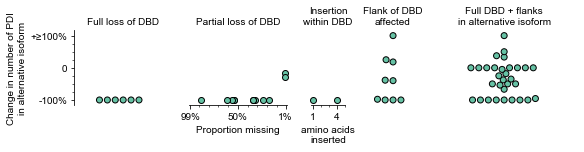

In [25]:
# TODO
# check y variable now that we use reference isoform
# horizontal line across whole

gs_kw = dict(width_ratios=[1, 1, 0.35, 0.4, 1.5])
fig, axs = plt.subplots(nrows=1, 
                        ncols=5,
                        sharey=True,
                        gridspec_kw=gs_kw)
fig.set_size_inches(w=8, h=2)
point_size = 6

axs[0].set_title('Full loss of DBD',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full loss\nof DBD',
                     ],
              ax=axs[0],
              color=sns.color_palette("Set2")[0],
              linewidth=1,
              edgecolor="black",
              alpha=1)

axs[1].set_title('Partial loss of DBD',
fontsize=10)
axs[1].scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
               df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            color=sns.color_palette("Set2")[0],
               linewidths=1,
               edgecolor="black",
           clip_on=False)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(100, 0)
axs[1].set_xticks([99, 50, 1])
axs[1].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[2].set_title('Insertion\nwithin DBD',
fontsize=10)
axs[2].scatter(df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'dbd_insertion_n_aa'].values,
               df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            color=sns.color_palette("Set2")[0],
               linewidths=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('amino acids\ninserted')
axs[2].set_xticks([1, 4])
axs[2].set_xticks(range(1, 6), minor=True)

axs[3].set_title('Flank of DBD\naffected',
                 fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'DBD flank affected',
                     ],
              ax=axs[3],
            color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              alpha=1)

axs[4].set_title('Full DBD + flanks\nin alternative isoform',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full DBD in\nalternative isoform',
                     ],
            color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              ax=axs[4],
              alpha=1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
for i in [0, 3, 4]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([-1, 0, 1])
axs[0].set_yticks(np.linspace(-1, 1, 9), minor=True)
axs[0].set_yticklabels(['-100%', '0', '+≥100%'])
axs[0].set_ylabel('Change in number of PDI\nin alternative isoform')

plt.savefig('../figures/DBD_or_flank_change_vs_PDI_composite.pdf', bbox_inches='tight')

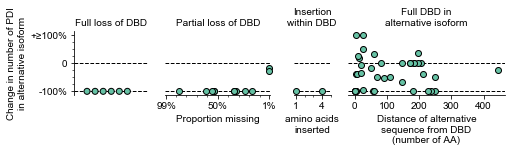

In [26]:
# try distance from DBD
# TODO
# check y variable now that we use reference isoform
# horizontal line across whole

gs_kw = dict(width_ratios=[0.7, 1, 0.35, 1.5])
fig, axs = plt.subplots(nrows=1, 
                        ncols=4,
                        sharey=True,
                        gridspec_kw=gs_kw)
fig.set_size_inches(w=7, h=2)
point_size = 6

axs[0].set_title('Full loss of DBD',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full loss\nof DBD',
                     ],
              ax=axs[0],
              color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              alpha=1,
             zorder=10)

axs[1].set_title('Partial loss of DBD',
fontsize=10)
axs[1].scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
               df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
           clip_on=False,
              zorder=10)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(100, 0)
axs[1].set_xticks([99, 50, 1])
axs[1].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[2].set_title('Insertion\nwithin DBD',
fontsize=10)
axs[2].scatter(df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'dbd_insertion_n_aa'].values,
               df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
           clip_on=False,
              zorder=10)
axs[2].set_xlabel('amino acids\ninserted')
axs[2].set_xticks([1, 4])
axs[2].set_xticks(range(1, 6), minor=True)

axs[3].set_title('Full DBD in\nalternative isoform', fontsize=10)
axs[3].scatter(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'dbd_n_aa_to_change'].values,
               df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
           clip_on=False,
               zorder=10)
axs[3].set_xlabel('Distance of alternative\nsequence from DBD\n(number of AA)')
#axs[3].set_xlim(100, 0)
#axs[3].set_xticks([99, 50, 1])
#axs[3].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
#axs[3].set_xticks(range(10, 91, 10), minor=True)


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
    ax.axhline(y=-1, linestyle="dashed", linewidth=1, color="black", zorder=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0, zorder=1)
for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([-1, 0, 1])
axs[0].set_yticks(np.linspace(-1, 1, 9), minor=True)
axs[0].set_yticklabels(['-100%', '0', '+≥100%'])
axs[0].set_ylabel('Change in number of PDI\nin alternative isoform')


plt.savefig('../figures/DBD_or_flank_change_vs_PDI_composite_alt_with_distance.pdf', bbox_inches='tight')

In [52]:
# full DBD in alternative isoform, fraction in disordered
df['f_disorder_difference'] = df.apply(lambda x: disordered_fraction_of_different_regions(tfs[x['gene']], x['ref_iso'], x['alt_iso']), axis=1)

In [70]:
df.dbd_affected.value_counts()

Full DBD in\nalternative isoform    43
Partial loss\nof DBD                12
Full loss\nof DBD                    7
Name: dbd_affected, dtype: int64

ax 0
ax 1


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


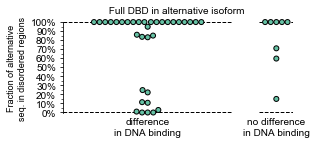

In [140]:
# check low values
gs_kw = dict(width_ratios=[2.5, 0.5])
fig, axarr = plt.subplots(1, 2, tight_layout=True, gridspec_kw=gs_kw, sharey=True)
fig.set_size_inches(h=2, w=4.5)

ax = axarr[0]
sns.swarmplot(data=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] != 0), :],
              y='f_disorder_difference',
              color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              ax=ax,
              clip_on=False
              )
ax.set_xlabel('difference\nin DNA binding')
ax.set_ylabel('Fraction of alternative\nseq. in disordered regions', fontsize=9)
ax.set_xticks([])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_ylim(-0.01, 1)
ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
ax.axhline(y=1, linestyle="dashed", linewidth=1, color="black", zorder=1)
ax.set_yticklabels(['{:.0%}'.format(y) for y in ax.get_yticks()])

ax = axarr[1]
sns.swarmplot(data=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] == 0), :],
              y='f_disorder_difference',
              color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              ax=ax,
              clip_on=False
              )
ax.set_xlabel('no difference\nin DNA binding')
ax.set_xticks([])
for loc in ['top', 'bottom', 'right', 'left']:
    ax.spines[loc].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(which='both', length=0, zorder=1)
ax.set_ylabel('')
ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
ax.axhline(y=1, linestyle="dashed", linewidth=1, color="black", zorder=1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('             Full DBD in alternative isoform\n', fontsize=10)
fig.savefig('../figures/disordered-pct-alt-sequence_alt-isoforms-full-DBD-diff-PDI_dotplot.pdf',
            bbox_inches='tight')

In [154]:
x = list(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] != 0), 'f_disorder_difference'])
y = list(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] == 0), 'f_disorder_difference'])

In [156]:
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=127.0, pvalue=0.19784554991837988)

## exon diagrams

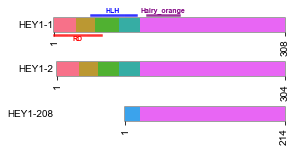

In [144]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs["HEY1"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)
fig.savefig("../figures/HEY1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

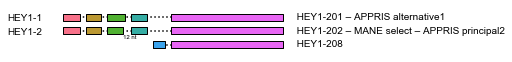

In [151]:
fig, ax = plt.subplots(figsize=(7, 0.75))

tfs["HEY1"].exon_diagram(ax=ax)
fig.savefig("../figures/HEY1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

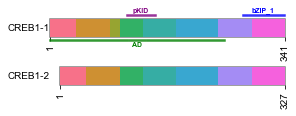

In [159]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs["CREB1"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../figures/CREB1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  after removing the cwd from sys.path.


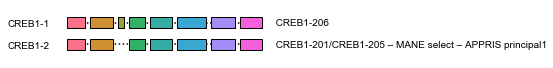

In [161]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs["CREB1"].exon_diagram(ax=ax)
fig.savefig("../figures/CREB1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")